In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [2]:
user_df = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')
eng_df = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])
user_df = user_df.rename({'object_id':'user_id'}, axis=1)
eng_df = eng_df.set_index('time_stamp')

In [3]:
user_df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
eng_df.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:00,1,1
2013-11-15 03:45:00,2,1
2013-11-29 03:45:00,2,1
2013-12-09 03:45:00,2,1
2013-12-25 03:45:00,2,1


Now that we have the data loaded, we need to get these adopted users denoted in the dataset. To do this, we can resample the data set down to one day at a time, then have this rolling window that will show people who have logged on 3 days out of 7, then will give a True or False value for if that person was engaged for the required amount of time.

In [5]:
users = eng_df.user_id.unique()
adopted = []

for i in users:
    user = eng_df.user_id == i
    df_filter = eng_df[user].resample('1D').count()
    df_filter = df_filter.rolling(window=7).sum()
    df_filter = df_filter.dropna()
    adopted.append(any(df_filter["visited"].values >= 7))

Now we have all of our engaged users marked. Time to put them all in the their own DataFrame, and join that data set with the users data set. 

In [6]:
user_adoption = list(zip(users, adopted))

df_adopt = pd.DataFrame(user_adoption)
df_adopt.columns = ["user_id", "adopted_user"]

df = user_df.merge(df_adopt, on="user_id", how="left")

Making the 'adopted_user' column into ones and zeros for true and false values will allow us to do some predictive modeling on this data set.

In [7]:
df.loc[:, "adopted_user"] = df["adopted_user"].map({False:0, True:1, np.nan:0})

It will also help to know if these people were invited into the service by someone else, and can be easily done with a lambda function

In [8]:
invite = lambda row: 0 if np.isnan(row) else 1
df["invited_by_user"] = df["invited_by_user_id"].apply(invite)

Now that we have all the features and columns the way we want them, let's put all the relevant features into their own data set that we can do some modeling of.

In [9]:
df = df[["adopted_user", "invited_by_user", "creation_source", "opted_in_to_mailing_list", "enabled_for_marketing_drip"]]
df

,adopted_user,invited_by_user,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip
0,0,1,GUEST_INVITE,1,0
1,0,1,ORG_INVITE,0,0
2,0,1,ORG_INVITE,0,0
3,0,1,GUEST_INVITE,0,0
4,0,1,GUEST_INVITE,0,0
...,...,...,...,...,...
11995,0,1,ORG_INVITE,0,0
11996,0,0,SIGNUP_GOOGLE_AUTH,0,0
11997,0,1,GUEST_INVITE,1,1
11998,0,0,PERSONAL_PROJECTS,0,0


I decided to use Gradient Boosting here because of the fact that each tree is not trained independently, and is instead trained off the previous one. That will lead to a more accurate model when the fitting is done than its closest competitor, Random Forest.

In [10]:
X = df.drop('adopted_user', axis=1)
y = df['adopted_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=11)

steps = [('encoder', OneHotEncoder()), ('gboost', GradientBoostingClassifier(random_state=11))]
param_grid = {'gboost__n_estimators': np.arange(10, 110, 10),
              'gboost__max_depth': np.arange(1, 6, 1)}

pipeline = Pipeline(steps)
cv = GridSearchCV(pipeline, param_grid, cv=3)
cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('encoder',
                                        OneHotEncoder(categories='auto',
                                                      drop=None,
                                                      dtype=<class 'numpy.float64'>,
                                                      handle_unknown='error',
                                                      sparse=True)),
                                       ('gboost',
                                        GradientBoostingClassifier(ccp_alpha=0.0,
                                                                   criterion='friedman_mse',
                                                                   init=None,
                                                                   learning_rate=0.1,
                                                                   loss='deviance',
                         

In [11]:
print(f'Gradient Boosting Best Parameters: {cv.best_params_}')
print(f'Training Score from best tuned model: {round(cv.best_score_*100, 2)}%')

Gradient Boosting Best Parameters: {'gboost__max_depth': 1, 'gboost__n_estimators': 10}
Training Score from best tuned model: 94.82%


In [12]:
y_pred = cv.predict(X_test)
test_score = accuracy_score(y_test, y_pred)
print(f'Model accuracy: {round(test_score*100, 2)}%')

Model accuracy: 94.83%


Really good accuracy overall. But we're here for the feature importances, so let's take a look at those. I decided to get some dummy variables because I wanted to see if the any of the creation sources in our data set had any effect on the model.

In [13]:
X_dums = pd.get_dummies(X_test)
pipeline.fit(X_dums, y_test)

importance = pipeline.named_steps['gboost'].feature_importances_

feature_importance = list(zip(X_dums.columns, importance))
feature_importances = pd.DataFrame.from_records(feature_importance, columns=['Feature', 'Importance'])
feature_importances = feature_importances.set_index('Feature').sort_values('Importance')
feature_importances

,Importance
Feature,
creation_source_SIGNUP,0.011505
creation_source_SIGNUP_GOOGLE_AUTH,0.014771
opted_in_to_mailing_list,0.030588
creation_source_ORG_INVITE,0.040380
invited_by_user,0.050039
creation_source_PERSONAL_PROJECTS,0.061309
enabled_for_marketing_drip,0.123917
creation_source_GUEST_INVITE,0.285108


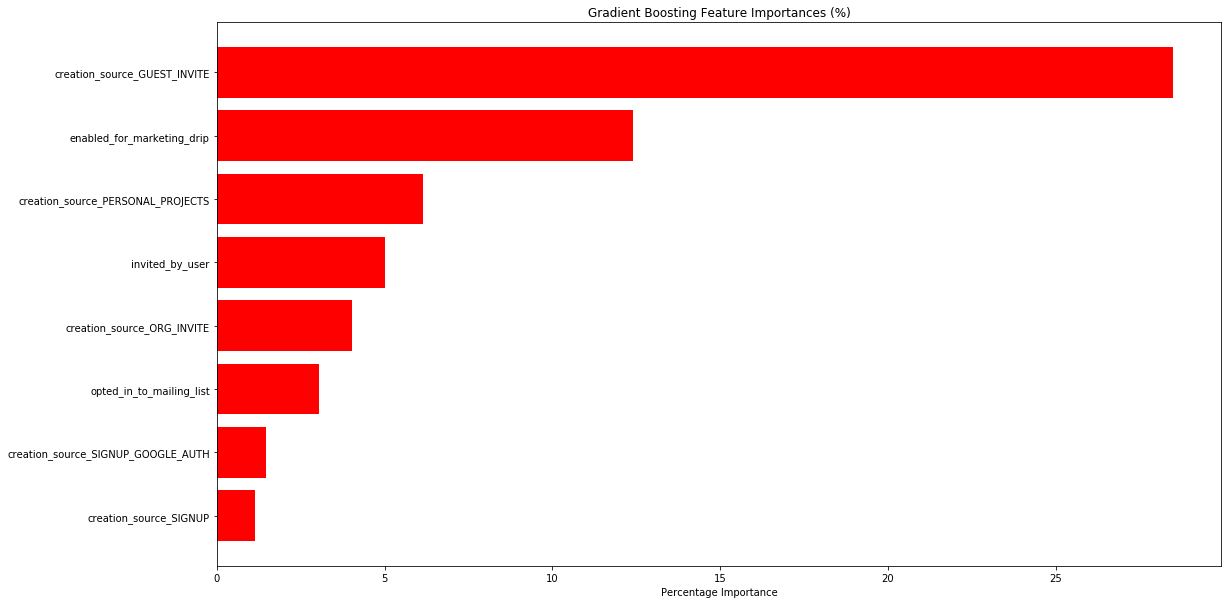

In [14]:
plt.figure(figsize=(18,10))
plt.barh(feature_importances.index, width=feature_importances['Importance'] * 100, color='r')
plt.title("Gradient Boosting Feature Importances (%)")
plt.xlabel('Percentage Importance')
plt.show()

Overall, we trained a good model for making predictions on user engagement. By taking a look at feature importances, the business can narrow down its marketing strategy and focus on what the most important features its using for getting and retaining users in the future. 

The most important feature, by a good margin, was guest invites. So people that are already guests and recommending this software to their peers are very important in user engagement on the site. Relax Inc. could adjust their marketing strategy to focus more on this and allow for collaborative efforts with user groups.

The next most important feature in this data set was whether these people were signed up for the marketing drip. Relax could find new ways of keeping users engaged with their marketing plan which will allow for more engagement with the software overall.